In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import SGD, Adam
from keras.utils.training_utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import prepare_data as pd
import numpy
import math
import scipy.misc as spm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from lr_multiplier import LearningRateMultiplier

import matplotlib
matplotlib.rc('image', cmap='gray')

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
def mse(x, y):
    return numpy.linalg.norm(x - y)

In [3]:
def psnr(target, ref):

    target_data = numpy.array(target, dtype=float)
    ref_data = numpy.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(numpy.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

In [168]:
def predict_model(network='9-3-5'):

    sgd = SGD(lr=0.0001)
    
    if network == '9-1-5':
        k = 1
    elif network == '9-3-5':
        k = 3
    else:
        k = 5
    
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), 
                     kernel_initializer='glorot_uniform', bias_initializer='random_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1), name='conv2d_1'))
    
    SRCNN.add(Conv2D(filters=64, kernel_size=(k, k), 
                     kernel_initializer='glorot_uniform', bias_initializer='random_uniform',
                     activation='relu', padding='same', use_bias=True, name='conv2d_2'))
        
    
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), 
                     kernel_initializer='glorot_uniform', bias_initializer='random_uniform',
                     activation='linear', padding='valid', use_bias=True,  name='conv2d_3'))
    adam = Adam(lr=0.0003)
    sgd_last = SGD(lr=0.00001)

    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

In [83]:
def predict(epoch=0, sample='pick', network='9-3-5'):

    srcnn_model = predict_model(network)
    srcnn_model.load_weights("checkpoints_64_52/64-{}_128-64-SRCNN_model_at_epoch_{}.h5".format(network, epoch))
    IMG_NAME = numpy.fromfile('ground_data/{}/recon/slice_256.b'.format(sample), dtype = 'uint8')
    INPUT_NAME = numpy.fromfile("sub_data/{}/recon/slice_256.b".format(sample), dtype = 'uint8')
    OUTPUT_NAME = "pre2.png"

    dimension_img = int(IMG_NAME.shape[0]**(1/2))
    dimension_input = int(INPUT_NAME.shape[0]**(1/2))
    
    IMG_NAME = IMG_NAME.reshape((dimension_img, dimension_img))
    INPUT_NAME = INPUT_NAME.reshape((dimension_input, dimension_input))
    
    import cv2
    img = INPUT_NAME.copy()
    shape = IMG_NAME.shape
    Y_img = img.copy()
    Y_img = spm.imresize(Y_img, size=shape, interp='bicubic')

    bicubic = Y_img.copy()

    Y_img = Y_img.reshape((dimension_img, dimension_img, 1))
    
    for i in range(Y_img.shape[-1]):
        Y = numpy.zeros((1, shape[0], shape[1], 1), dtype=float)
        Y[0,:,:,0] = Y_img[:,:,i].astype(float) / 255.
        pre = srcnn_model.predict(Y, batch_size=1) * 255.
        
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(float)
#     print(Y_img.shape, pre.shape)
    Y_img[6: -6, 6: -6, 0] = pre[0, :, :, 0].copy()
    cv2.imwrite(OUTPUT_NAME, Y_img)

    # psnr calculation:
    im1 = IMG_NAME
    im2 = bicubic
    im3 = cv2.imread(OUTPUT_NAME)[:,:,0]
    
#     im1 = im1[10:-10,10:-10]/im1.max()
#     im2 = im2[10:-10,10:-10]/im2.max()
#     im3 = im3[10:-10,10:-10]/im3.max()
    
    im1 = im1[10:-10,10:-10]
    im2 = im2[10:-10,10:-10]
    im3 = im3[10:-10,10:-10]


#     print(im1.shape, im2.shape, im3.shape)

#     print ("bicubic:")
#     print (cv2.PSNR(im1, im2))
#     print ("SRCNN:")
#     print (cv2.PSNR(im1, im3))

    ssim_12 = ssim(im1, im2, data_range=im1.max() - im1.min())
    ssim_13 = ssim(im1, im3, data_range=im1.max() - im1.min())
    ssim_23 = ssim(im2, im3, data_range=im2.max() - im2.min())
    
#     print("\nSSIM bicubic: {}".format(ssim_12))
#     print("SSIM SRCNN: {}".format(ssim_13))
#     print("SSIM bicubic x SRCNN: {}\n".format(ssim_23))
    
    mse_12 = mse(im1, im2)
    mse_13 = mse(im1, im3)
    mse_23 = mse(im2, im3)
    
#     print("MSE bicubic: {}".format(mse_12))
#     print("MSE SRCNN: {}".format(mse_13))
#     print("MSE bicubic x SRCNN: {}".format(mse_23))
    
#     import matplotlib.pyplot as plt
#     print(im1.shape)
#     plt.figure(figsize=[15,30])
#     plt.subplot(311)
#     plt.title('Original')
#     plt.imshow(im1)
#     plt.subplot(312)
#     plt.title('Bicubic')    
#     plt.imshow(im2)
#     plt.subplot(313)
#     plt.title('SRCNN')
#     plt.imshow(im3)
#     plt.show()
    
    return ssim_12, ssim_13, ssim_23, mse_12, mse_13, mse_23

In [84]:
print(predict(100,'pick', network='9-3-5'))

/home/ABTLUS/fernando.furusato/tests/jupyter/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(0.32075228500987074, 0.34479371916319185, 0.4377281307495457, 82657.00940029224, 117144.88378926329, 121290.12614800927)


In [170]:
srcnn_model = predict_model('9-3-5')
srcnn_model.load_weights("checkpoints_64_52/64-{}_128-64-SRCNN_model_at_epoch_{}.h5".format('9-3-5', 999))

In [115]:
def read_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
#         label = numpy.array(hf.get('label'))
#         train_data = numpy.transpose(data, (0, 2, 3, 1))
#         train_label = numpy.transpose(label, (0, 2, 3, 1))
        print(data.shape)
#         print(label.shape)
        return data

In [116]:
data = read_data("sub_data/sub_data_pick.h5")


(512, 256, 256)


In [145]:
label = read_data("ground_data/ground_data_pick.h5")

(512, 512, 512)


In [123]:
new_data = numpy.empty((512, 512, 512, 1))
for i in range(data.shape[0]):
    new_data[i,:,:,0] = spm.imresize(data[i,:,:], size=(512, 512), interp='bicubic')
new_data.shape

/home/ABTLUS/fernando.furusato/tests/jupyter/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(512, 512, 512, 1)

In [171]:
prediction = srcnn_model.predict(new_data)

In [230]:
ssim(label[:,6:-6,6:-6], prediction[:,:,:,0], data_range=label.max() - label.min())

0.6860394143984447

In [234]:
ssim(label, new_data[:,:,:,0], data_range=label.max() - label.min())

0.6367843747652243

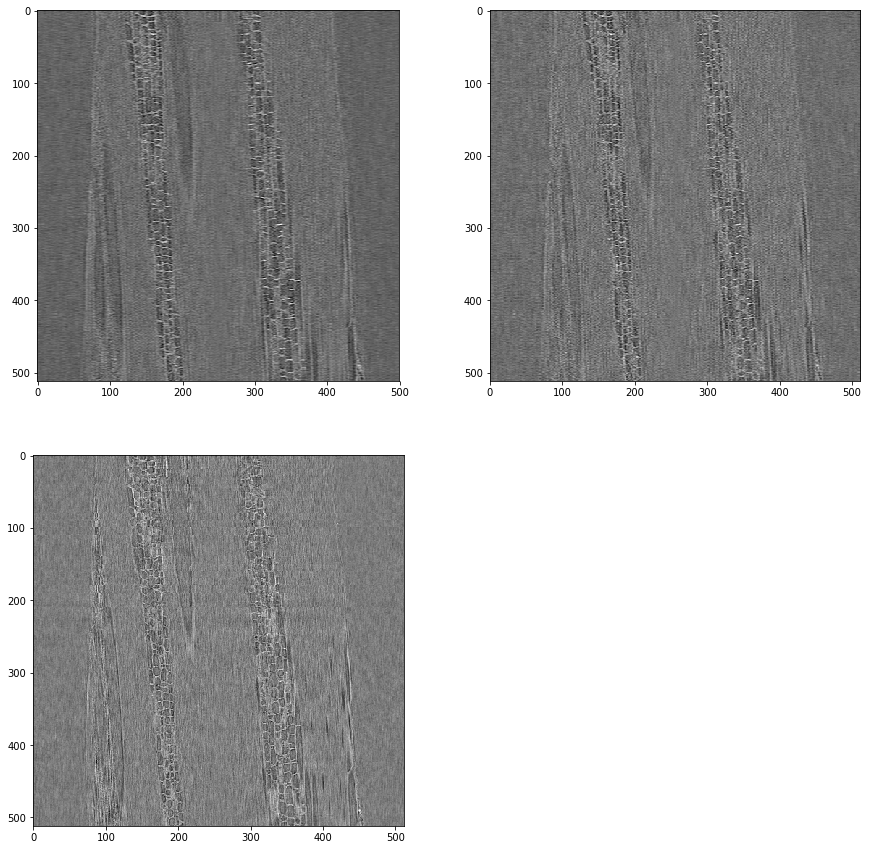

In [172]:
plt.figure(figsize=[15,15])

plt.subplot(221)
plt.imshow(prediction[:,:,250,0])

plt.subplot(222)
plt.imshow(new_data[:,:,256,0])

plt.subplot(223)
plt.imshow(label[:,:,256])
plt.show()

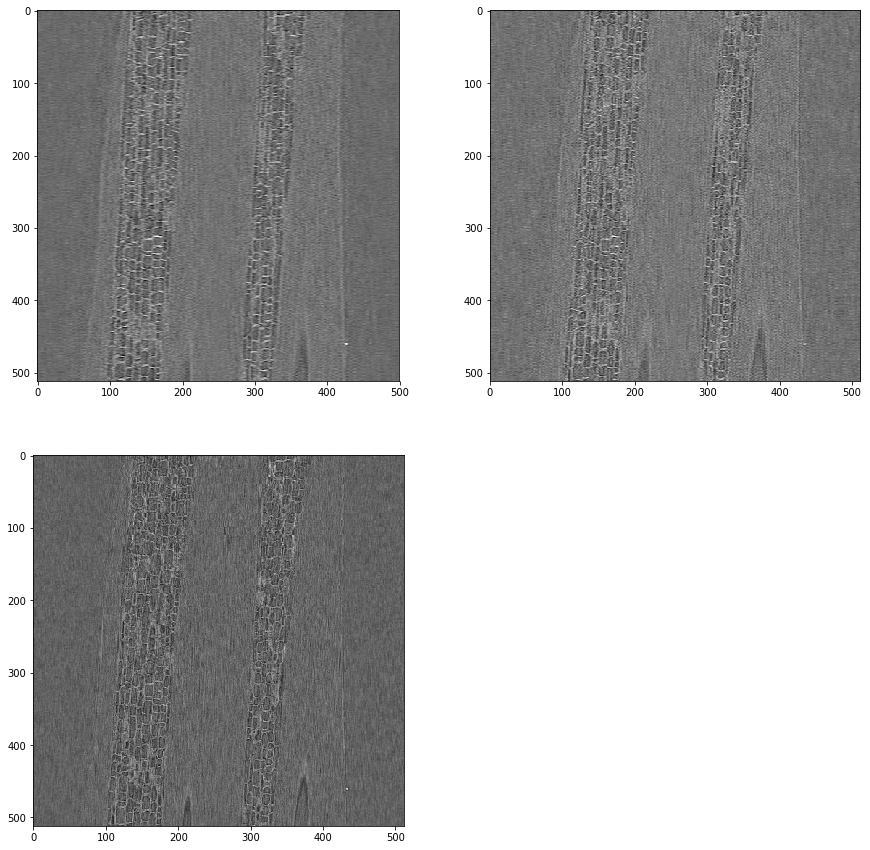

In [181]:
plt.figure(figsize=[15,15])

plt.subplot(221)
plt.imshow(prediction[:,250,:,0])

plt.subplot(222)
plt.imshow(new_data[:,256,:,0])

plt.subplot(223)
plt.imshow(label[:,256,:])
plt.show()

In [178]:
srcnn_model.evaluate(prediction, label.reshape((512, 512, 512, 1))[:, 12:-12, 12:-12, : ])

512/512 [==============================] - 3s 7ms/step


[212.66913604736328, 212.66913604736328]

In [224]:
%matplotlib notebook

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'up', 'down'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
#     fig.canvas.mpl_connect('key_press_event', process_key)
    fig.canvas.mpl_connect('scroll_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
#     if event.key == 'j':
    if event.button == 'up':
        previous_slice(ax)
#     elif event.key == 'k':
    elif event.button == 'down':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    plt.title('Slice {}'.format(ax.index))
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    


<IPython.core.display.Javascript object>


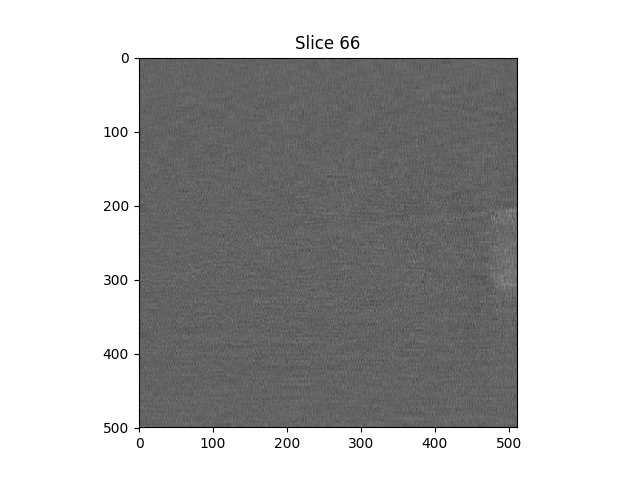

In [225]:
multi_slice_viewer(prediction[:,:,:,0].transpose())

<IPython.core.display.Javascript object>


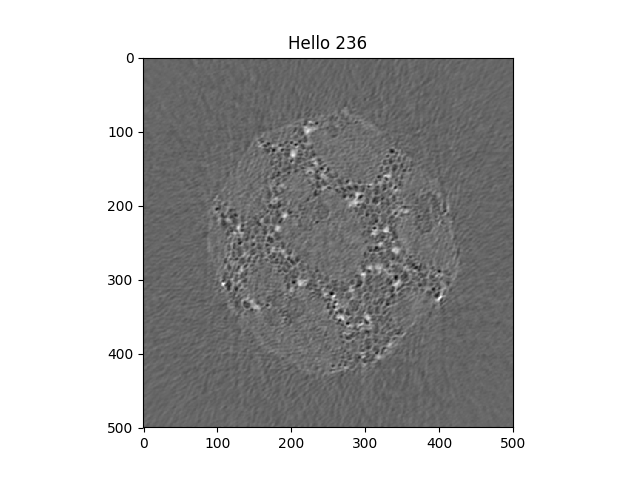

In [221]:
multi_slice_viewer(prediction[:,:,:,0])